In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
%matplotlib inline
parameters = {'axes.unicode_minus': False,
              'font.sans-serif':'SimHei',
              'axes.facecolor':'0.98',
              'axes.labelsize': 16,
              'axes.titlesize': 16,
              'xtick.labelsize': 16,
              'ytick.labelsize': 16}
plt.rcParams.update(parameters)


from backtest import Broker, Trade
from model import arima, rollingOLS
from utils import data_tools
from sklearn.model_selection import train_test_split

import rqdatac as rq
from rqdatac import *
rq.init('18817204954', '123456')

# 导入数据

## 导入甲醇制烯烃利润数据

In [7]:
# 甲醇制烯烃利润数据     
dt= data_tools(table_name='./data/ma_raw_data.xlsx', sheet_name='需求特征', header=7, index_col=0, names=['甲醇制烯烃利润'])
profit_df = dt.load_data(select_date='2017-05-31')
profit_df.fillna(method='ffill', inplace=True)
profit_df.head()

,甲醇制烯烃利润
2017-05-31,181.68
2017-06-01,146.16
2017-06-02,-14.58
2017-06-05,-144.58
2017-06-06,-109.58


In [9]:
# 获取甲醇期货主力连续合约行情数据 [20170823, 20220513]
# future_price_df = pd.DataFrame(futures.get_dominant_price('MA',start_date='2017-08-23',end_date='2022-05-13',frequency='1d',fields=None, adjust_type='pre', adjust_method='prev_close_ratio'))['open']
future_price_df = pd.DataFrame(futures.get_dominant_price('MA',start_date='2017-05-31',end_date='2022-05-13',frequency='1d',fields=None, adjust_type='pre', adjust_method='prev_close_ratio'))['open']
future_price_df.index = [ind for code, ind in future_price_df.index]
future_price_df = future_price_df.to_frame()
future_price_df.rename(columns={'open':'甲醇期货主连开盘价'}, inplace=True)
future_price_df.head()

,甲醇期货主连开盘价
2017-05-31,2982.414565
2017-06-01,2808.231529
2017-06-02,2849.584336
2017-06-05,2775.650530
2017-06-06,2809.484645


# 直接择时模型

## 对基差数据进行稳定性和随机性检验

### ADFuller Test - 稳定性检验
>结论：
    > 1. 原始数据在显著性水平为0.05下，有95%的置信度认为当前时间序列是稳定的，显著性水平为0.01下，是不稳定的
    > 2. 对数据进行1阶差分后，在显著性水平为[0.01, 0.05, 0.1]下均为稳定的，并且无向上或向下趋势

Augmented Dickey-Fuller Test on 甲醇制烯烃利润
Null Hypothesis(原假设): Data has unit root. Non-Stationary（不稳定）.
Test statistic(检验统计量) = -4.202
P-value(P值) = 0.001
Critical values :
	当显著性水平为1%: 决断值为-3.434 ==> The data is  stationary with 99% confidence
	当显著性水平为5%: 决断值为-2.863 ==> The data is  stationary with 95% confidence
	当显著性水平为10%: 决断值为-2.568 ==> The data is  stationary with 90% confidence


Augmented Dickey-Fuller Test on 甲醇制烯烃利润 (一阶差分)
Null Hypothesis(原假设): Data has unit root. Non-Stationary（不稳定）.
Test statistic(检验统计量) = -13.976
P-value(P值) = 0.000
Critical values :
	当显著性水平为1%: 决断值为-3.434 ==> The data is  stationary with 99% confidence
	当显著性水平为5%: 决断值为-2.863 ==> The data is  stationary with 95% confidence
	当显著性水平为10%: 决断值为-2.568 ==> The data is  stationary with 90% confidence




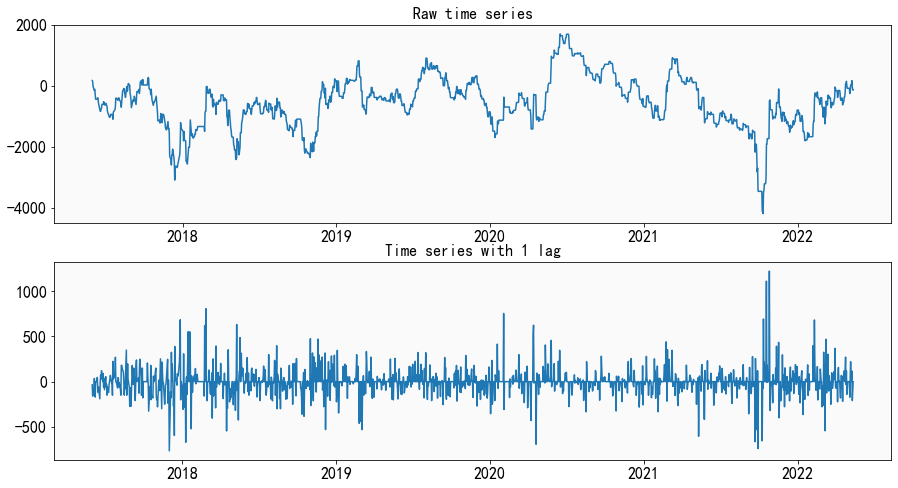

In [10]:
dt.time_series_analysis(profit_df) 

### Ljung-Box - 随机性检验
> 结论：
    > 1至20阶滞后的序列所得p值均小于0.05，说明该序列不是白噪声数据，不具有随机性，因此数据有价值，可以继续分析

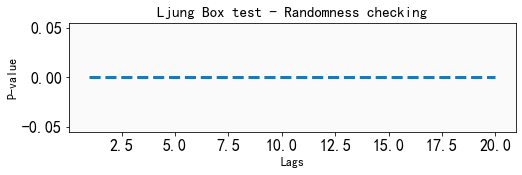

In [12]:
# 对基差进行1阶差分, 并填充后向缺失值
# profit_df['主流现货基差1期差分'] = profit_df.fillna(method='bfill')
# 检验1阶滞后范围内序列的自相关性是否显著（或是否为白噪声）
dt.residual_check(df=profit_df['甲醇制烯烃利润'], lags=20)

## ARIMA模型参数选择

### ACF（自相关性）和PACF（偏自相关性）分析
> 判断：
     > 1. ACF拖尾，PACF截尾 => AR(p)
     > 2. ACF截尾，PACF拖尾 => MA(q)
     > 3. ACF拖尾，PACF拖尾 => ARMA(p,q)
     
> 结论：
    > 据下图分析，ACF在lag=1处截尾，PACF也在lag=1处截尾，因此初步取ARIMA(1,1,1)

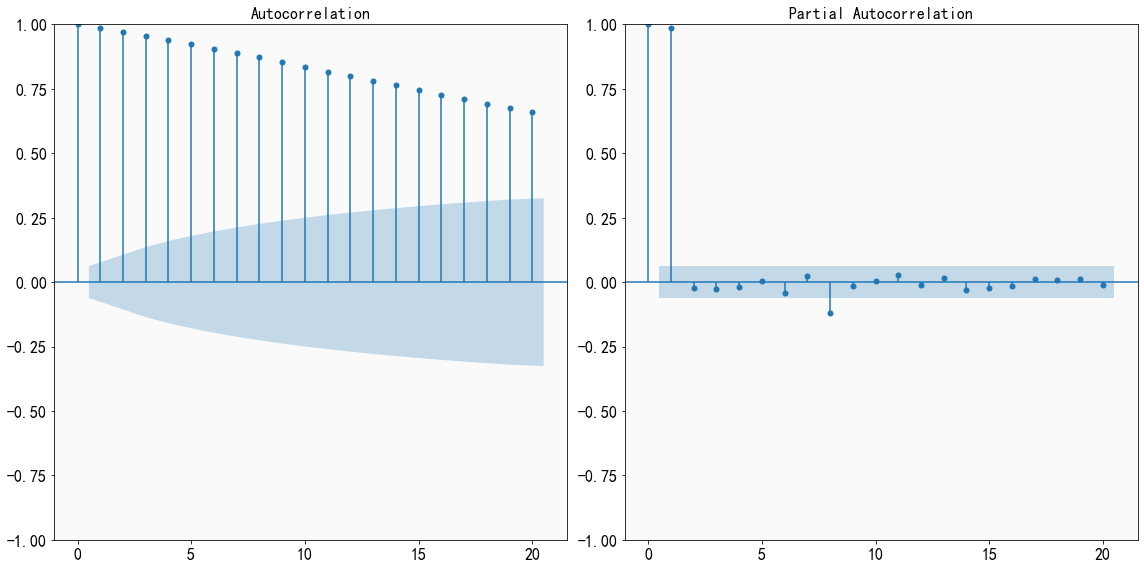

In [13]:
dt.acf_pacf_plot(df=profit_df['甲醇制烯烃利润'], lags=20, alpha=0.01)

### AIC准则 - 对参数进行Grid Search
> 结论：
    > 基于AIC准则，为避免参数过多造成模型过拟合，不选择AIC最小时对应的(p,d,q)=(4,1,3),而选择AIC次小时对应的(p,d,q)=(1,1,1)，与ACF,PACF中分析结果一致

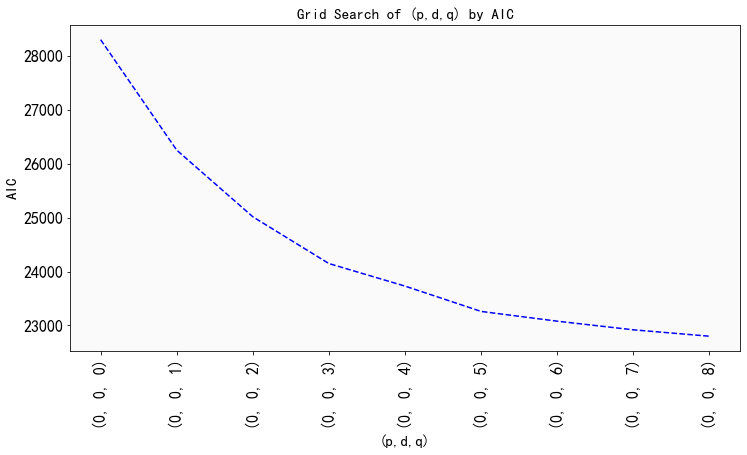

(0, 0, 8)

In [15]:
best_order = dt.grid_search_aic_arima(df=profit_df['甲醇制烯烃利润'], p=[0], d=[0], q=range(0, 9))
best_order

## 生成直接择时信号
> ARIMA模型训练：
    基于当前交易日前10个历史日收益（相当于2周）滚动构建ARIMA模型，并对当前交易日基差进行预测（样本外进行One-step ahead prediction）

> 阈值设定：
    为当前交易日前一天的基差值
    
> 策略：
    若预测基差大于（小于）阈值, 则在下一期做多（做空）标的期货

### Arima模型训练与预测

In [16]:
# 对每个交易日，使用之前的10个历史日收益（相当于2周）滚动构建ARIMA模型，并对该日的基差预测
direct_signal_df = arima().train_predict(df=profit_df['甲醇制烯烃利润'], window=10, order=(0,0,8), columns=['Index', '甲醇制烯烃利润_predict', '甲醇制烯烃利润_previous', '甲醇制烯烃利润_true'])

# 应用策略
position_list = []
for i in range(len(direct_signal_df)):
    position_list.append(-1 if direct_signal_df['甲醇制烯烃利润_predict'][i] > direct_signal_df['甲醇制烯烃利润_previous'][i] else 1 if direct_signal_df['甲醇制烯烃利润_predict'][i] < direct_signal_df['甲醇制烯烃利润_previous'][i] else 0)
direct_signal_df = pd.concat([direct_signal_df, pd.DataFrame(position_list, columns=['Position'], index = direct_signal_df.index)], axis=1)
direct_signal_df.head()

,甲醇制烯烃利润_predict,甲醇制烯烃利润_previous,甲醇制烯烃利润_true,Position
Index,,,,
2017-06-14,-325.206419,-384.34,-458.05,-1
2017-06-15,-384.533260,-458.05,-578.05,-1
2017-06-16,-516.749943,-578.05,-638.28,-1
2017-06-19,-642.150794,-638.28,-828.97,1
2017-06-20,-882.949897,-828.97,-828.97,1


### 甲醇期货主连收益率和净值计算

In [17]:
# 合并数数据
df = direct_signal_df.merge(future_price_df, left_index=True, right_index=True)
# 计算甲醇期货主力合约收益率
df['甲醇期货主连收益率'] = df['甲醇期货主连开盘价'].pct_change().shift(-1)
df['净值'] = (df['Position'] * df['甲醇期货主连收益率'] + 1).cumprod()
df.fillna(method='ffill', inplace=True)
df.head()

,甲醇制烯烃利润_predict,甲醇制烯烃利润_previous,甲醇制烯烃利润_true,Position,甲醇期货主连开盘价,甲醇期货主连收益率,净值
2017-06-14,-325.206419,-384.34,-458.05,-1,2869.634182,0.023581,0.976419
2017-06-15,-384.533260,-458.05,-578.05,-1,2937.302412,-0.023891,0.999747
2017-06-16,-516.749943,-578.05,-638.28,-1,2867.127951,0.021853,0.977899
2017-06-19,-642.150794,-638.28,-828.97,1,2929.783720,0.016253,0.993793
2017-06-20,-882.949897,-828.97,-828.97,1,2977.402103,-0.010101,0.983755


## 回测
> 结论：
    > 可以看出，择时收益在2020年来跑赢了基准收益，回测期内2020年至2022年，年化收益率分别为10.03%， 29.39%， 21.17%。该择时指标在2017年至2019年期间表现较差，求得负收益。
    

年份         2017      2018      2019      2020      2021      2022
年化收益率 -0.163427 -0.003142 -0.536195 -0.030349 -0.450884 -0.605335
年化波动率  0.022460  0.015922  0.015063  0.020564  0.023001  0.038308
最大回撤率 -0.163533 -0.259487 -0.544774 -0.294377 -0.554935 -0.315586
夏普率   -0.032464  0.013660 -0.200019  0.005737 -0.095424 -0.297776
卡玛比率   0.999351  0.012107  0.984253  0.103097  0.812500  1.918129


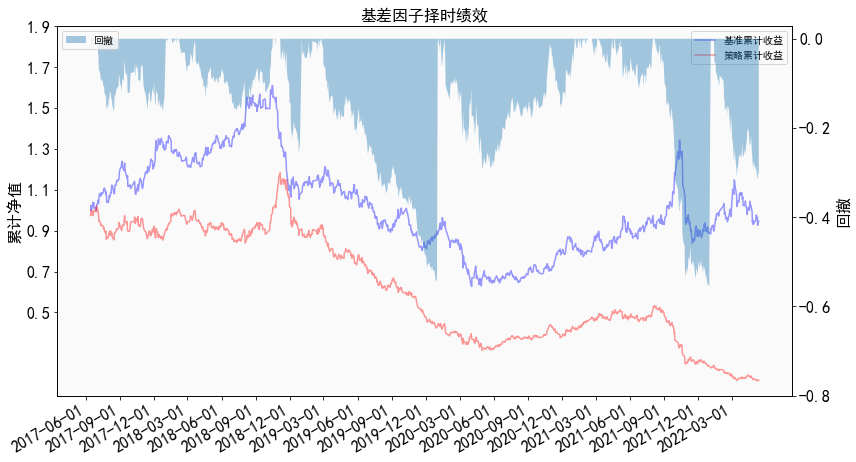

In [18]:
broker_arima = Broker()
broker_arima.set_backtest(df[['甲醇期货主连开盘价', '净值']])  # 回测只需要“甲醇期货主连开盘价”和“净值”
trade_arima = Trade(broker_arima)
trade_arima.extract_year_month_week(is_year=True)
# 计算每日收益率
trade_arima.daily_return()
# 计算基准累计收益
trade_arima.basic_cum_return()
print(trade_arima.factor_summary())
trade_arima.backtest_graph(title="基差因子择时绩效")

# OLS滚动回归择时模型

In [19]:
# 合并数数据
df_ols = profit_df.merge(future_price_df, left_index=True, right_index=True)
# 计算甲醇期货主力合约收益率
df_ols['甲醇期货主连收益率'] = df_ols['甲醇期货主连开盘价'].pct_change().shift(-1)
df_ols.head()

,甲醇制烯烃利润,甲醇期货主连开盘价,甲醇期货主连收益率
2017-05-31,181.68,2982.414565,-0.058403
2017-06-01,146.16,2808.231529,0.014726
2017-06-02,-14.58,2849.584336,-0.025945
2017-06-05,-144.58,2775.650530,0.012190
2017-06-06,-109.58,2809.484645,0.026316


##  OLS滚动回归择时模型训练与预测

In [20]:
ret_df = rollingOLS().train_predict(df=df_ols, window = 11, columns=['甲醇制烯烃利润', '甲醇期货主连收益率'])

## 甲醇期货主连收益率和净值计算

In [21]:
# 设定阈值（取指标的分位数）
# thresholds = [ret_df.quantile(q)[0] for q in [_.round(2) for _ in np.arange(0.1, 1, 0.1)]]

# 仓位判断
ret_df = pd.concat([ret_df, pd.DataFrame([1 if ret_f > 0.01 else -1 if ret_f < -0.01 else 0 for ret_f in ret_df['预测收益率']], columns=['Position'], index = ret_df.index)], axis=1)
print("当前仓位情况：\n", ret_df.groupby(['Position'])['Position'].count())

# 净值计算
ret_df['净值'] = (ret_df['Position'].to_frame() .shift(-2).fillna(method='ffill')['Position'] * ret_df['预测收益率'] + 1).cumprod()
ret_df.fillna(method='ffill', inplace=True)

# 合并数据
ret_df = ret_df.merge(df_ols['甲醇期货主连开盘价'], left_index=True, right_index=True)
ret_df.head()

当前仓位情况：
 Position
-1    154
 0    871
 1    170
Name: Position, dtype: int64


,预测收益率,Position,净值,甲醇期货主连开盘价
2017-06-14,0.009521,0,1.0,2869.634182
2017-06-15,-0.003013,0,1.0,2937.302412
2017-06-16,0.005237,0,1.0,2867.127951
2017-06-19,0.003887,0,1.0,2929.783720
2017-06-20,-0.000171,0,1.0,2977.402103


## 回测

年份          2017       2018       2019      2020        2021        2022
年化收益率   1.352354   0.740913   0.374371  0.315120    3.316764    5.653326
年化波动率   0.010934   0.006685   0.004794  0.005649    0.013455    0.023489
最大回撤率  -0.021126  -0.014308  -0.015759 -0.032753   -0.027662   -0.011581
夏普率     0.573230   0.344957   0.274376  0.206840    0.455127    0.975438
卡玛比率  -64.015224 -51.781410 -23.756685 -9.621245 -119.901988 -488.151095


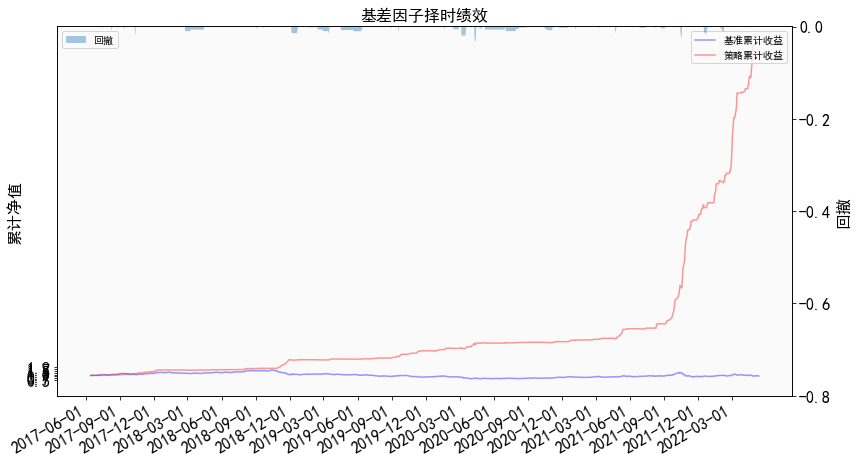

In [22]:
broker_rollingOLS = Broker()
broker_rollingOLS.set_backtest(ret_df[['甲醇期货主连开盘价', '净值']])  # 回测只需要“甲醇期货主连开盘价”和“净值”
trade_rollingOLS = Trade(broker_rollingOLS)
trade_rollingOLS.extract_year_month_week(is_year=True)
# 计算每日收益率
trade_rollingOLS.daily_return()
# 计算基准累计收益
trade_rollingOLS.basic_cum_return()
print(trade_rollingOLS.factor_summary())
trade_rollingOLS.backtest_graph(title="基差因子择时绩效")